# Analyze RAGIS simulations

In [5]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_imbie_csv
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.stats import run_stats

In [6]:
n_jobs = 8
norm_year = 1992.0

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertainty_varname = "SMB uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load IMBIE

In [7]:
# imbie = load_imbie(url="../imbie_dataset_greenland_dynamics-2020_02_28.xlsx")
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

## Make a list of all experiments

In [12]:
data_dir = "../hindcasts"

exps = []

exps.append({
    "Experiment": "tct",
    "proj_dir": "2023_05_calving_simple",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_calving_simple_lhs_50",
}
)

## Process experiments

In [52]:
experiments = []

for exp in exps:

    ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
    s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
    scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
    processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])

    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.98it/s]


Conversion finished in 8 seconds
-------------------------------------------
-------------------------------------------



Processing date: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:25<00:00,  1.58it/s]

Program finished in 26 seconds


Peformace Summary for Experiment tct (50 members)
---------------------------------------------------

processor_hours                   35542.817251
wall_clock_hours                    740.475359
model_years_per_processor_hour        0.058384
dtype: float64
---------------------------------------------------



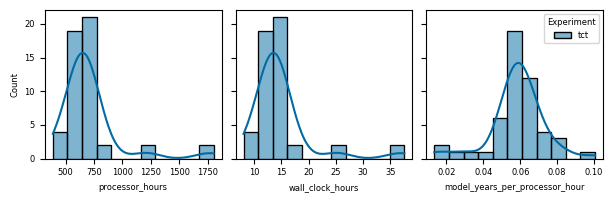

In [53]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

e = experiments[0]["run_stats"]
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
fig.savefig("run_stats.pdf")
!open run_stats.pdf

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

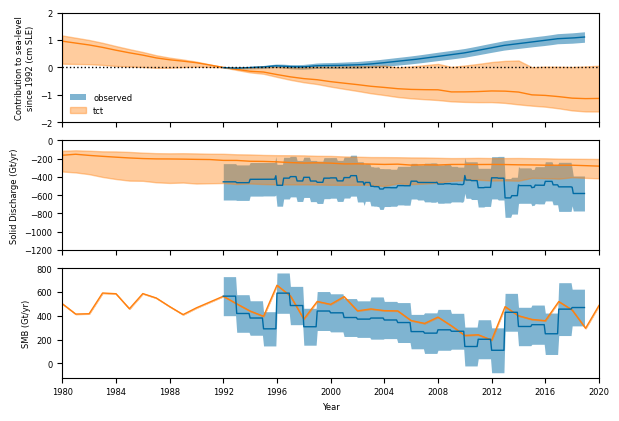

In [54]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 4.2))
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

obs_ci = axs[0].fill_between(imbie["Date"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5, label="observed")
axs[1].fill_between(imbie["Date"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)
axs[2].fill_between(imbie["Date"], 
                    (imbie[smb_varname] + sigma * imbie[smb_uncertainty_varname]), 
                    (imbie[smb_varname] - sigma * imbie[smb_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)

for k, exp in enumerate(experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=1)

    axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.4, lw=1, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.4, lw=1)
    axs[2].fill_between(q_05.index, q_05[smb_varname], 
                        q_95[smb_varname], color=sim_colors[k], alpha=0.4, lw=1)

axs[0].plot(imbie["Date"], imbie[mass_varname], color=imbie_color, lw=1)
axs[1].plot(imbie["Date"], imbie[discharge_varname], color=imbie_color, lw=1)
axs[2].plot(imbie["Date"], imbie[smb_varname], color=imbie_color, lw=1)



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-2.0, 2.0)
axs[1].set_ylim(-1200, 0)
#axs[1].set_ylim(-1000, 100)

legend = axs[0].legend(loc="lower left")
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

## Plot sensitivity index

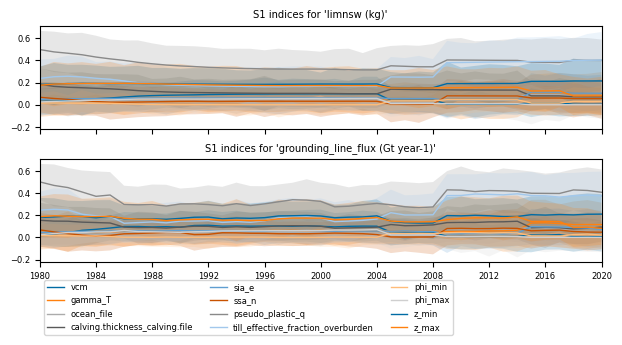

In [55]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [38]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

Experiment 0: -2975.03
Experiment 1: -5585.93
Experiment 2: -6432.18
Experiment 3: -7815.31
Experiment 4: -6504.83
Experiment 5: -326.97
Experiment 6: -7461.12
Experiment 7: -6482.53
Experiment 8: -5194.08
Experiment 9: -4018.91
Experiment 10: -4167.72
Experiment 11: -5590.86
Experiment 12: -2366.61
Experiment 13: -4989.37
Experiment 14: -5230.26
Experiment 15: -6857.03
Experiment 16: -3682.65
Experiment 17: -4592.84
Experiment 18: -5170.89
Experiment 19: -8267.51
Experiment 20: -4663.89
Experiment 21: -7193.22
Experiment 22: -5642.97
Experiment 23: -7283.25
Experiment 24: -2201.65
Experiment 25: -3631.08
Experiment 26: -6404.14
Experiment 27: -3753.94
Experiment 28: -8622.23
Experiment 29: -4188.67
Experiment 30: -7254.25
Experiment 31: -7164.14
Experiment 32: -7098.48
Experiment 34: -5155.34
Experiment 35: -5823.74
Experiment 36: -4089.79
Experiment 37: -564.13
Experiment 38: -1405.47
Experiment 42: -76.99
Experiment 48: -167.78


/Users/andy/Library/Python/3.11/lib/python/site-packages/pismragis/analysis.py:331: RuntimeWarning: overflow encountered in exp
  weights = np.exp(w)
/Users/andy/Library/Python/3.11/lib/python/site-packages/pismragis/analysis.py:332: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()


ValueError: probabilities contain NaN

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
from scipy.interpolate import interp1d
from tqdm import tqdm


In [ ]:
np.array([  634.45744104  -235.12952599 -1167.45917464  -531.87414125
  -904.57676904    91.04033758   722.82730577   114.16742036
   423.55949261   625.02532308  -293.90580578   647.25631402
  -586.31879794 -1381.01064481   349.68201297   716.26847793
   363.33248697 -1011.23876497   -48.85983816   406.46475582
   605.17371227  -949.29602232  -988.06082517  -534.95763144
   405.57114816  -986.00865133  -649.38528098   665.06762932
   625.46368323   385.91494928 -1067.25259603  1053.83389006
   230.25552736  -390.24453682   176.72057353 -1066.75620664
  -303.09711807   312.49178881   942.86270865   783.1536109
   111.79503873  -139.82581505   570.4991376   -757.75426472
   586.62399324    39.56232318   879.51778518   524.42354351]
[  634.45744104  -235.12952599 -1167.45917464  -531.87414125
  -904.57676904    91.04033758   722.82730577   114.16742036
   423.55949261   625.02532308  -293.90580578   647.25631402
  -586.31879794 -1381.01064481   349.68201297   716.26847793
   363.33248697 -1011.23876497   -48.85983816   406.46475582
   605.17371227  -949.29602232  -988.06082517  -534.95763144
   405.57114816  -986.00865133  -649.38528098   665.06762932
   625.46368323   385.91494928 -1067.25259603  1053.83389006
   230.25552736  -390.24453682   176.72057353 -1066.75620664
  -303.09711807   312.49178881   942.86270865   783.1536109
   111.79503873  -139.82581505   570.4991376   -757.75426472
   586.62399324    39.56232318   879.51778518   524.42354351])

In [ ]:
np.exp(weights)

In [ ]:
imbie

In [ ]:
e

In [ ]:
calib_exps

In [ ]:
e

In [ ]:
m_e

In [ ]:
experiments[1]["data_df"]

In [ ]:
m_e = experiments[2]["data_df"]

In [ ]:
m_e

In [ ]:
def resample_ensemble_by_data_o(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, observed_mean, observed_std in zip(
            observed_calib_period["Year"],
            observed_calib_period[m_var],
            observed_calib_period[m_var_std],
        ):
            try:
                observed_std *= fudge_factor
                exp_mean = exp_interp(year)

                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled


In [ ]:
def resample_ensemble_by_data(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, exp_mean in zip(exp_["Year"], exp_[m_var]):
            try:
                observed_mean = observed_interp_mean(year)
                observed_std = observed_interp_std(year) * fudge_factor
                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
                print(i, year, f"{observed_mean:.3f}", f"{observed_std:.3f}", f"{exp_mean:.3f}")

            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled, weights

In [ ]:
import xarray as xr

In [ ]:
xr.open_dataset("../../pism-emulator/pddemulator/DMI-HIRHAM5_1980_2020_MMS.nc")

In [46]:
exp_df

,time,id,basal_mass_flux_floating (Gt year-1),basal_mass_flux_grounded (Gt year-1),dt (year),grounding_line_flux (Gt year-1),ice_area_glacierized (m2),ice_area_glacierized_cold_base (m2),ice_area_glacierized_floating (m2),ice_area_glacierized_grounded (m2),...,tendency_of_ice_mass_glacierized (Gt year-1),tendency_of_ice_volume (m3 year-1),tendency_of_ice_volume_glacierized (m3 year-1),Year,resolution_m,Mass (Gt),SLE (cm),D (Gt/yr),SMB (Gt/yr),Experiment
0,1980-01-01,0,-414.014103,-19.536890,0.002772,-253.965827,1.771742e+12,1.081842e+12,3.624275e+09,1.768118e+12,...,-861.058582,-9.384295e+11,-9.462182e+11,1980.0,1200,-1630.069614,0.449674,-253.965827,500.651026,tct
1,1981-01-01,0,-222.879511,-16.765520,0.002658,-255.982343,1.770066e+12,1.071504e+12,2.009522e+09,1.768056e+12,...,-358.988104,-3.944171e+11,-3.944924e+11,1981.0,1200,-1485.639774,0.409832,-255.982343,413.799873,tct
2,1982-01-01,0,-114.201908,-18.430522,0.002626,-269.152487,1.769331e+12,1.066771e+12,1.001333e+09,1.768330e+12,...,-124.676683,-1.367644e+11,-1.370073e+11,1982.0,1200,-1353.416976,0.373356,-269.152487,416.738957,tct
3,1983-01-01,0,-75.839215,-18.741927,0.002615,-292.962941,1.769732e+12,1.063999e+12,6.013795e+08,1.769131e+12,...,107.657638,1.188615e+11,1.183051e+11,1983.0,1200,-1151.921376,0.317771,-292.962941,590.639722,tct
4,1984-01-01,0,-59.629429,-21.245883,0.002613,-323.462407,1.770560e+12,1.061947e+12,4.463764e+08,1.770114e+12,...,113.703844,1.249764e+11,1.249493e+11,1984.0,1200,-916.601424,0.252856,-323.462407,584.844562,tct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,2016-01-01,9,-26.021835,-25.822600,0.001500,-351.735458,1.770868e+12,1.027529e+12,1.428393e+08,1.770725e+12,...,-30.337831,-3.213034e+10,-3.333828e+10,2016.0,1200,1482.793202,-0.409046,-351.735458,359.803817,tct
37,2017-01-01,9,-26.216921,-24.455191,0.001477,-353.581948,1.770817e+12,1.027468e+12,1.446944e+08,1.770672e+12,...,125.841798,1.357020e+11,1.382877e+11,2017.0,1200,1559.305914,-0.430153,-353.581948,519.766747,tct
38,2018-01-01,9,-26.190458,-24.946377,0.001467,-351.269189,1.770850e+12,1.027690e+12,1.443196e+08,1.770705e+12,...,58.409891,6.323994e+10,6.418669e+10,2018.0,1200,1680.455794,-0.463574,-351.269189,449.114278,tct
39,2019-01-01,9,-23.888086,-24.601168,0.001486,-348.420348,1.770577e+12,1.027478e+12,1.268936e+08,1.770450e+12,...,-83.072598,-9.356291e+10,-9.128857e+10,2019.0,1200,1679.416699,-0.463287,-348.420348,296.675513,tct


In [49]:
experiments[0].items()

dict_items([('Experiment', 'tct'), ('proj_dir', '2023_05_calving_simple'), ('scalar_dir', 'scalar'), ('processed_dir', 'processed'), ('lhs', 'gris_ragis_calving_simple_lhs_50'), ('data_df',          time  id  basal_mass_flux_floating (Gt year-1)  \
0  1980-01-01   0                           -414.014103   
1  1981-01-01   0                           -222.879511   
2  1982-01-01   0                           -114.201908   
3  1983-01-01   0                            -75.839215   
4  1984-01-01   0                            -59.629429   
..        ...  ..                                   ...   
36 2016-01-01   9                            -26.021835   
37 2017-01-01   9                            -26.216921   
38 2018-01-01   9                            -26.190458   
39 2019-01-01   9                            -23.888086   
40 2020-01-01   9                            -27.269258   

    basal_mass_flux_grounded (Gt year-1)  dt (year)  \
0                             -19.536890   0.0

In [50]:
uq_df = pd.read_csv("../uq/gris_ragis_calving_simple_lhs_50.csv")

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'vcm'}>,
        <Axes: title={'center': 'gamma_T'}>],
       [<Axes: title={'center': 'sia_e'}>,
        <Axes: title={'center': 'ssa_n'}>,
        <Axes: title={'center': 'pseudo_plastic_q'}>],
       [<Axes: title={'center': 'till_effective_fraction_overburden'}>,
        <Axes: title={'center': 'phi_min'}>,
        <Axes: title={'center': 'phi_max'}>],
       [<Axes: title={'center': 'z_min'}>,
        <Axes: title={'center': 'z_max'}>, <Axes: >]], dtype=object)

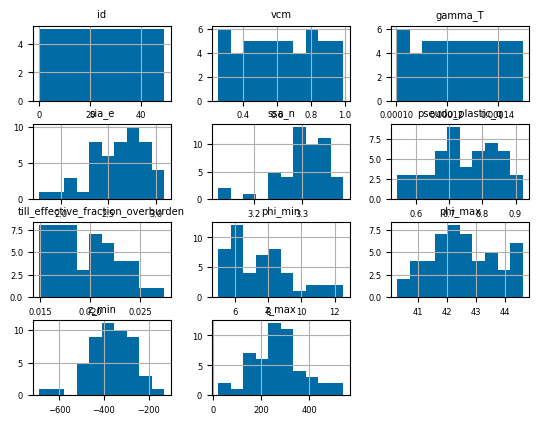

In [51]:
uq_df.hist()